In [ ]:
# unable colab to access git
!git clone https://github.com/yifeica0/ECS171-Group8.git
%cd ECS171-Group8
!git checkout models

Cloning into 'ECS171-Group8'...
remote: Enumerating objects: 585, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 585 (delta 89), reused 141 (delta 51), pack-reused 392 (from 1)
Receiving objects: 100% (585/585), 176.33 MiB | 45.15 MiB/s, done.
Resolving deltas: 100% (247/247), done.
/content/ECS171-Group8/ECS171-Group8
Branch 'models' set up to track remote branch 'models' from 'origin'.
Switched to a new branch 'models'


In [ ]:
# update repo informations
!git pull

Already up to date.


In [ ]:
import pandas as pd
import torch
from tqdm.notebook import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [ ]:
# load extended data for text sentiment
df = pd.read_parquet('datasets/extended_datasets/amazon_user_reviews_text_sentiment_extended.parquet')

df.head()

,sentiment,text_cleaned
0,2,imagine someone use skin worse using fine sand...
1,2,way small
2,2,absolutely junk bit even stay total waste mone...
3,2,smell great seen improvement keep trying see a...
4,2,broke less week heavy


In [ ]:
# distribution and unique values of the sentiment column
print(df['sentiment'].value_counts())


sentiment
2    12375
0    12368
1    12197
Name: count, dtype: int64


In [ ]:
print('Installing transformers library...')
!pip install transformers
print('Transformers library installed.')

Installing transformers library...
Transformers library installed.


## 3-Category BERT Model

3-category sentiment analysis (Negative, Neutral, Positive).


In [ ]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

print(f'Loading tokenizer for {model_name}...')
tokenizer = AutoTokenizer.from_pretrained(model_name)
print('Tokenizer loaded.')

print(f'Loading model for {model_name}...')
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print('Model loaded.')

Loading tokenizer for cardiffnlp/twitter-roberta-base-sentiment-latest...
Tokenizer loaded.
Loading model for cardiffnlp/twitter-roberta-base-sentiment-latest...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded.


In [ ]:
# see if there are avialable model that is faster
def get_device():
    # 1. Try CUDA (NVIDIA GPU)
    if torch.cuda.is_available():
        print("CUDA (GPU) is available. Using CUDA.")
        return torch.device("cuda")

    # 2. Try TPU (Requires torch_xla, e.g., in Google Colab)
    # This check depends on your environment setup
    try:
        import torch_xla.core.xla_model as xm
        print("TPU is available. Using TPU.")
        return xm.xla_device()
    except ImportError:
        pass # TPU not available or library not installed

    # 3. Fallback to CPU
    print("No CUDA or TPU detected. Using CPU.")
    return torch.device("cpu")


In [ ]:
# Filter out any non-string or effectively empty values from 'text_cleaned'
df_filtered = df[df['text_cleaned'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)].copy()

# Create a list of texts to process from the filtered DataFrame
texts = df_filtered['text_cleaned'].tolist()

# Prepare for batch processing (optional, but good practice for large datasets)
batch_size = 32 # Adjust based on your CPU memory. Smaller batch size might be needed for large models on CPU.

predicted_sentiments = []

print('Starting sentiment prediction (forcing CPU execution due to persistent CUDA errors)...')

# Explicitly re-initialize model and tokenizer for CPU to prevent any lingering CUDA state
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
print(f'Re-loading tokenizer for {model_name}...')
tokenizer = AutoTokenizer.from_pretrained(model_name)
print('Tokenizer re-loaded.')

print(f'Re-loading model for {model_name} directly to CPU...')
# Load the model without map_location, then explicitly move to CPU
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print('Model re-loaded.')

# Ensure the model is explicitly on CPU after loading
device = get_device()
model.to(device)



# Define a fixed max_length for the tokenizer.
# RoBERTa-based models typically use 512 or 514. Let's use 512 for robustness.
# This ensures all attention_mask tensors have a consistent shape.
max_token_length = 512

for i in tqdm(range(0, len(texts), batch_size), desc='Predicting sentiments'):
    batch_texts = texts[i:i + batch_size]

    # Tokenize the batch of texts
    tokenized = tokenizer(
        batch_texts,
        return_tensors='pt',
        padding='max_length',    # Pad to max_length
        truncation=True,         # Truncate sequences longer than max_token_length
        max_length=max_token_length # Explicitly define max length
    )

    # Manually construct encoded_input to ensure maximum control over tensor properties
    input_ids = tokenized['input_ids'].long()

    # Explicitly create attention_mask from input_ids to ensure it's 1s for tokens, 0s for padding
    # This bypasses any potential subtle issues with tokenizer's default attention_mask output if any.
    # The pad_token_id for roberta is usually 1, but we can check tokenizer.pad_token_id
    attention_mask = (input_ids != tokenizer.pad_token_id).int() # Should be 0 for pad, 1 for others. Convert to int.

    # Check for NaN/Inf values (though less likely after filtering and explicit construction)
    if torch.isnan(input_ids).any() or torch.isinf(input_ids).any():
        print(f"Warning: NaN or Inf found in 'input_ids' for batch starting at index {i}. Skipping batch.")
        predicted_sentiments.extend([np.nan] * len(batch_texts))
        continue
    if torch.isnan(attention_mask).any() or torch.isinf(attention_mask).any():
        print(f"Warning: NaN or Inf found in 'attention_mask' for batch starting at index {i}. Skipping batch.")
        predicted_sentiments.extend([np.nan] * len(batch_texts))
        continue

    encoded_input = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    # Move input tensors to the CPU
    # Since model is already on CPU, inputs should also be on CPU.
    # The .to(device) here should be fine as device is 'cpu'.
    try:
        final_encoded_input = {k: v.clone().detach().to(device) for k, v in encoded_input.items()}
    except RuntimeError as e:
        print(f"RuntimeError during .to(device) for batch starting at index {i}: {e}")
        print("This indicates a CPU tensor issue. Trying to recover by skipping batch.")
        predicted_sentiments.extend([np.nan] * len(batch_texts))
        continue

    # Make predictions
    with torch.no_grad():
        output = model(**final_encoded_input)

    # Get predicted labels (logits to probabilities, then argmax)
    logits = output.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    predicted_sentiments.extend(predictions)

# Create a new column for predicted sentiment in the filtered DataFrame
df_filtered['predicted_sentiment'] = predicted_sentiments[:len(df_filtered)]

# Merge the predictions back to the original DataFrame, handling non-string rows as NaN for predicted_sentiment
df['predicted_sentiment'] = np.nan
df.loc[df_filtered.index, 'predicted_sentiment'] = df_filtered['predicted_sentiment']

print('Sentiment prediction complete.')
df.head()

Starting sentiment prediction (forcing CPU execution due to persistent CUDA errors)...
Re-loading tokenizer for cardiffnlp/twitter-roberta-base-sentiment-latest...
Tokenizer re-loaded.
Re-loading model for cardiffnlp/twitter-roberta-base-sentiment-latest directly to CPU...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-6451/87983142.py:12: DeprecationWarning: Use torch_xla.device instead
  return xm.xla_device()


Model re-loaded.
TPU is available. Using TPU.


Predicting sentiments:   0%|          | 0/1155 [00:00<?, ?it/s]

Sentiment prediction complete.


,sentiment,text_cleaned,predicted_sentiment
0,2,imagine someone use skin worse using fine sand...,0.0
1,2,way small,1.0
2,2,absolutely junk bit even stay total waste mone...,0.0
3,2,smell great seen improvement keep trying see a...,2.0
4,2,broke less week heavy,1.0


## Evaluate Model Performance



In [ ]:
from sklearn.metrics import classification_report

# Handle potential NaN values by dropping rows where predicted_sentiment is NaN
df_eval = df.dropna(subset=['predicted_sentiment']).copy()

# Extract true and predicted sentiment labels
y_true = df_eval['sentiment']
y_pred = df_eval['predicted_sentiment']

# Convert to integer data types if not already (important for classification_report)
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.04      0.04     12368
           1       0.42      0.43      0.43     12197
           2       0.12      0.16      0.14     12375

    accuracy                           0.21     36940
   macro avg       0.20      0.21      0.20     36940
weighted avg       0.20      0.21      0.20     36940



## Confusion Matrix


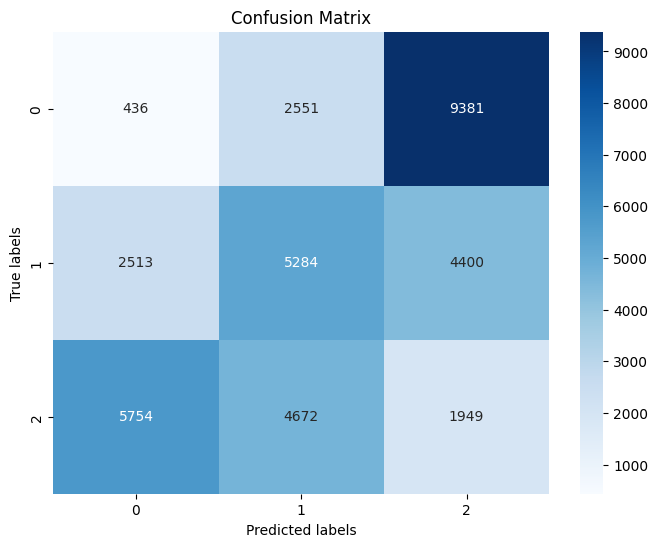

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### ROC Curve

In [ ]:
# Handle potential NaN values by dropping rows where predicted_sentiment is NaN
# This needs to be done *after* all probability columns have been added to df
df_eval = df.dropna(subset=['predicted_sentiment', 'prob_0', 'prob_1', 'prob_2']).copy()

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Iterate through each class label (0: Negative, 1: Neutral, 2: Positive)
for i in range(3):
    # Create binary true labels for the current class (one-vs-rest)
    y_true_binary = (df_eval['sentiment'] == i).astype(int)

    # Extract the predicted probabilities for the current class
    y_prob = df_eval[f'prob_{i}']

    # Calculate the ROC curve
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_prob)

    # Calculate the AUC score
    roc_auc[i] = auc(fpr[i], tpr[i])

print("ROC curve data and AUC scores calculated for all classes.")
print("AUC Scores:")
for i in range(3):
    print(f"Class {i} (One-vs-Rest): AUC = {roc_auc[i]:.2f}")

ROC curve data and AUC scores calculated for all classes.
AUC Scores:
Class 0 (One-vs-Rest): AUC = 0.18
Class 1 (One-vs-Rest): AUC = 0.63
Class 2 (One-vs-Rest): AUC = 0.21


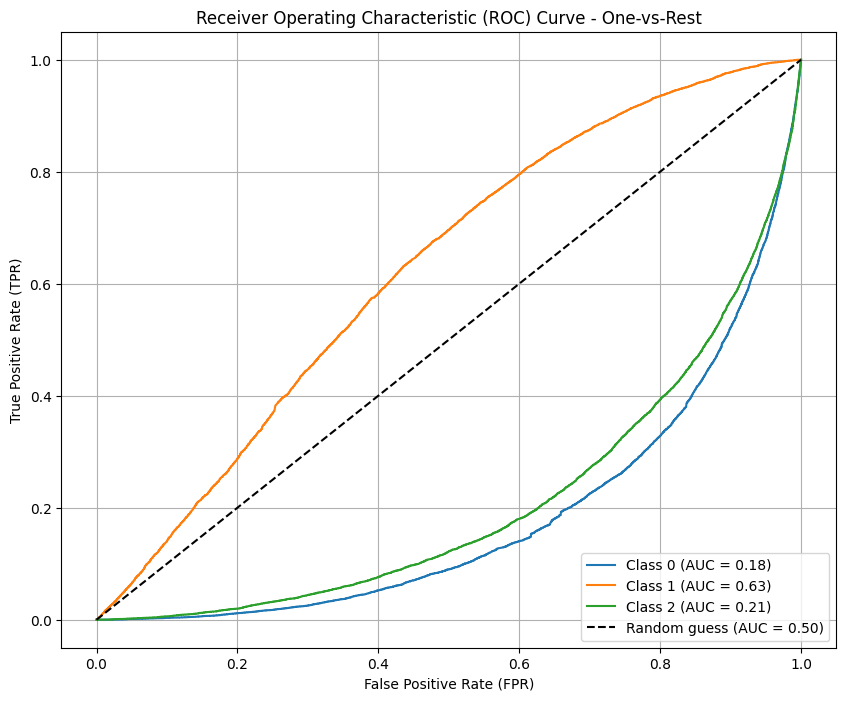

ROC curves visualized.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random guess (AUC = 0.50)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("ROC curves visualized.")